In [1]:
import numpy as np
import pandas as pd
import tqdm
import argparse
import os
import shutil
import pickle
from ai_clinician.modeling.models.komorowski_model import *
from ai_clinician.modeling.models.common import *
from ai_clinician.modeling.columns import C_OUTCOME
from ai_clinician.preprocessing.utils import load_csv
from ai_clinician.preprocessing.columns import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()



In [2]:
rrt_cols = [
    'Ultrafiltrate_Output',
    'Blood_Flow',
    'Hourly_Patient_Fluid_Removal',
    'Dialysate_Rate',
    'Hemodialysis_Output',  # Ensure the column name matches your DataFrame
    'Citrate',
    'Prefilter_Replacement_Rate',
    'Postfilter_Replacement_Rate'
]

In [3]:
def create_args():
    parser = argparse.ArgumentParser(description=(
        'Evaluates an AI Clinician model on the MIMIC-IV test set.'
    ))
    parser.add_argument('data', type=str,
                        help='Model data directory (should contain train and test directories)')
    parser.add_argument('model', type=str,
                        help='Path to pickle file containing the model')
    parser.add_argument('--out', dest='out_path', type=str, default=None,
                        help='Path to pickle file at which to write out results (optional)')
    parser.add_argument('--gamma', dest='gamma', type=float, default=0.99,
                        help='Decay for reward values (default 0.99)')
    parser.add_argument('--soften-factor', dest='soften_factor', type=float, default=0.01,
                        help='Amount by which to soften factors (random actions will be chosen this proportion of the time)')
    parser.add_argument('--num-iter-ql', dest='num_iter_ql', type=int, default=6,
                        help='Number of bootstrappings to use for TD learning (physician policy)')
    parser.add_argument('--num-iter-wis', dest='num_iter_wis', type=int, default=500,
                        help='Number of bootstrappings to use for WIS estimation (AI policy)')
    
    # Simulate command-line arguments
    simulated_input = [
        '/home/lkapral/RRT_mimic_iv/data/model',     # Replace with your actual data directory
        '/home/lkapral/RRT_mimic_ivl/data/model/models/model_params/best_model.pkl',    # Replace with your actual model path
        '--gamma', '0.99',
        '--soften-factor', '0.01',
        '--num-iter-ql', '6',
        '--num-iter-wis', '500'
    ]
    
    return parser.parse_args(simulated_input)

# Use the args
args = create_args()

data_dir = args.data
model = AIClinicianModel.load(args.model)
assert model.metadata is not None, "Model missing metadata needed to generate actions"

n_cluster_states = model.n_cluster_states

# Update the number of actions to 2 (binary actions)
n_actions = 2
model.n_actions = n_actions  # Update model's n_actions

# Define action_medians and action_bins for binary actions
action_medians = np.array([0, 1])
action_bins = np.array([0, 0.5, 1])

# Update model's action_bins and action_medians
model.metadata['actions']['action_bins'] = action_bins
model.metadata['actions']['action_medians'] = action_medians

 

FileNotFoundError: [Errno 2] No such file or directory: '/home/lkapral/RRT_mimic_ivl/data/model/models/model_params/best_model.pkl'

In [4]:
MIMICraw = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))

MIMICzs = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
unique_icu_stays = metadata[C_ICUSTAYID].unique()

# Create actions based on RRT
print("Create actions")

# Define RRT-related columns


# Create 'action' column
rrt_actions = (~MIMICraw[rrt_cols].isna() & (MIMICraw[rrt_cols] != 0)).any(axis=1)
MIMICraw['action'] = rrt_actions.astype(int)
# Actions array
actions = MIMICraw['action'].values

np.seterr(divide='ignore', invalid='ignore')



Create actions


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
MIMICraw['RRT'] = MIMICraw['action']
MIMICzs['RRT'] = MIMICraw['action']

In [6]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

In [7]:

# Load Training Data
MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
MIMICzs_train = pd.read_csv(os.path.join(data_dir, "train", "MIMICzs.csv"))
metadata_train = load_csv(os.path.join(data_dir, "train", "metadata.csv"))
# Load Testing Data
MIMICraw_test = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
MIMICzs_test = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata_test = load_csv(os.path.join(data_dir, "test", "metadata.csv"))

rrt_actions = (~MIMICraw_train[rrt_cols].isna() & (MIMICraw_train[rrt_cols] != 0)).any(axis=1)
MIMICraw_train['RRT'] = rrt_actions.astype(int)

rrt_actions = (~MIMICraw_test[rrt_cols].isna() & (MIMICraw_test[rrt_cols] != 0)).any(axis=1)
MIMICraw_test['RRT'] = rrt_actions.astype(int)

MIMICraw_train['icustayid'] = metadata_train['icustayid']
MIMICraw_test['icustayid'] = metadata_test['icustayid']

In [8]:
MIMICraw_train['action_offest'] = MIMICraw_train.groupby('icustayid')['RRT'].shift(-1).fillna(0).astype(int)
MIMICraw_test['action_offest'] = MIMICraw_test.groupby('icustayid')['RRT'].shift(-1).fillna(0).astype(int)

In [9]:
#MIMICzs_train['RRT']  = MIMICraw_train['RRT']  
#MIMICzs_test['RRT']  = MIMICraw_test['RRT']  

In [10]:

MIMICzs_train.drop(columns=rrt_cols, inplace=True)
MIMICzs_test.drop(columns=rrt_cols, inplace=True)

In [12]:


# Ensure that the number of rows matches between MIMICzs and MIMICraw
assert MIMICzs_train.shape[0] == MIMICraw_train.shape[0], "Training data row mismatch."
assert MIMICzs_test.shape[0] == MIMICraw_test.shape[0], "Testing data row mismatch."

# Prepare Features (X) and Target (y) for Training
X_train = MIMICzs_train.copy()
y_train = MIMICraw_train['action_offest']

# Prepare Features (X) and Target (y) for Testing
X_test = MIMICzs_test.copy()
y_test = MIMICraw_test['action_offest']

# Import necessary libraries for model optimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid to search
param_grid = {
    'n_estimators': [ 200, 300],         # Number of trees in the forest

}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=3,
                           scoring='accuracy',
                           )  # Increased verbosity)  # You can change scoring based on your problem

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
model = grid_search.best_estimator_
print("Best Hyperparameters:\n", grid_search.best_params_)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ..................n_estimators=200;, score=0.972 total time= 3.8min
[CV 2/3] END ..................n_estimators=200;, score=0.973 total time= 3.8min
[CV 3/3] END ..................n_estimators=200;, score=0.974 total time= 4.0min
[CV 1/3] END ..................n_estimators=300;, score=0.972 total time= 5.7min
[CV 2/3] END ..................n_estimators=300;, score=0.973 total time= 5.7min
[CV 3/3] END ..................n_estimators=300;, score=0.974 total time= 5.9min
Best Hyperparameters:
 {'n_estimators': 300}


Model Accuracy on Test Set: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    120125
           1       0.85      0.30      0.45      4344

    accuracy                           0.97    124469
   macro avg       0.91      0.65      0.72    124469
weighted avg       0.97      0.97      0.97    124469


Feature Importance Rankings:
                      Feature  Importance
0                 output_step    0.079535
1           cumulated_balance    0.038431
2                  Creatinine    0.037533
3                        SOFA    0.037266
4                   Anion_Gap    0.028939
..                        ...         ...
88                         T3    0.000549
89  Gamma_Glutamyltransferase    0.000234
90                Heparin_LMW    0.000065
91     APACHEII_Renal_Failure    0.000000
92           Osmolality_Urine    0.000000

[93 rows x 2 columns]


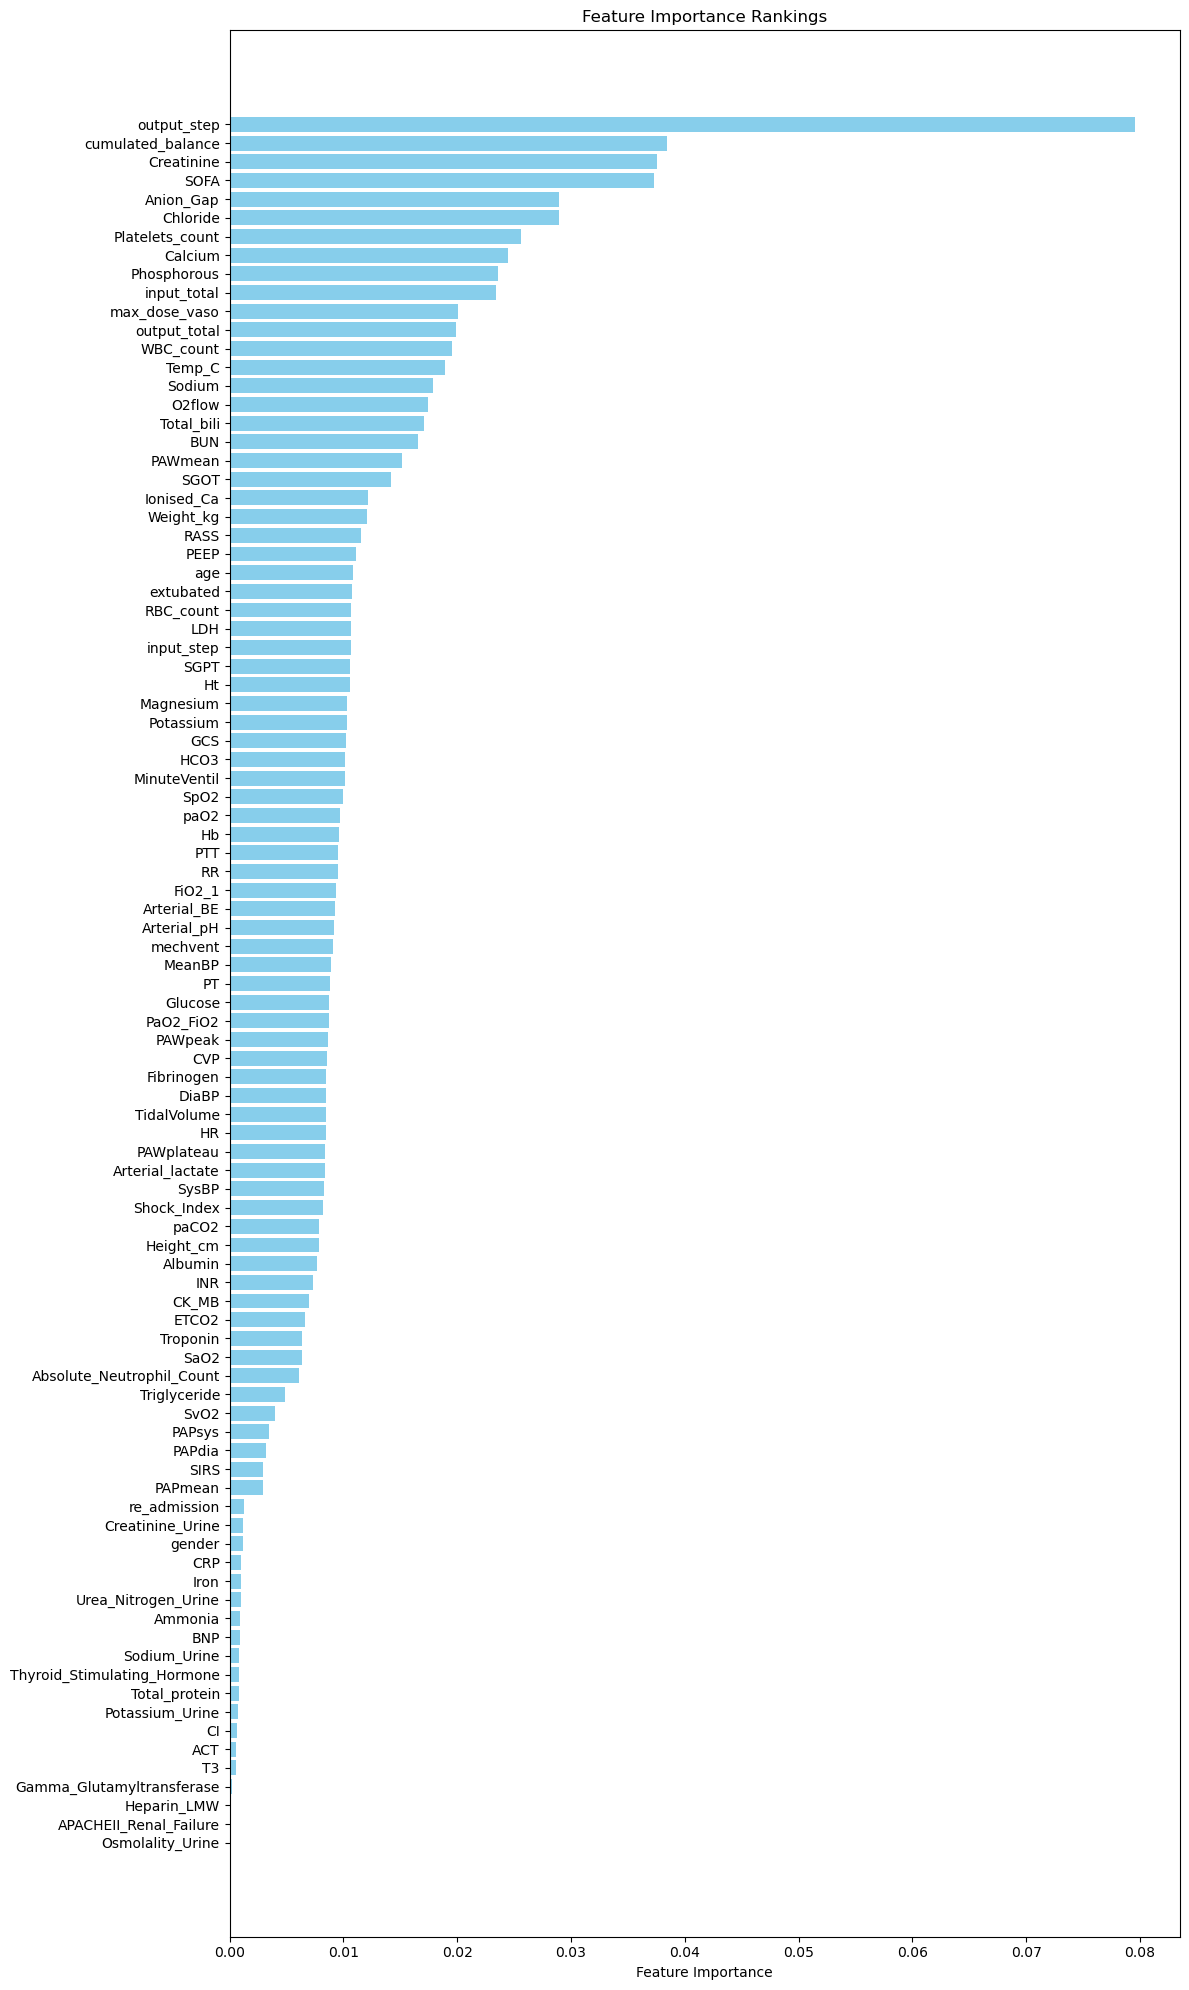

In [13]:
y_pred = model.predict(X_test)

# Evaluate Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Extract Feature Importances
feature_importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort Features by Importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nFeature Importance Rankings:")
print(importance_df)

# Plot Feature Importances
plt.figure(figsize=(12, 20))
plt.title("Feature Importance Rankings")
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Optional: Save Feature Importances to a CSV File
importance_df.to_csv(os.path.join(data_dir, "feature_importances.csv"), index=False)

AUROC: 0.97


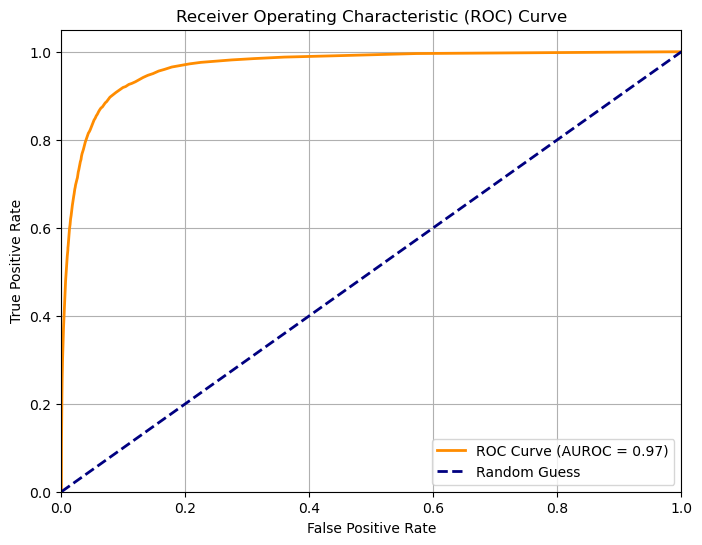

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Get predicted probabilities for the positive class (class '1')
y_prob = model.predict_proba(X_test)[:, 1]

# ===========================================
# Step 3: Compute ROC Curve and AUROC
# ===========================================

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute Area Under the ROC Curve (AUROC)
auroc = roc_auc_score(y_test, y_prob)
print(f"AUROC: {auroc:.2f}")

# ===========================================
# Step 4: Plot the ROC Curve
# ===========================================

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [16]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
# Load Training Data
MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
MIMICzs_train = pd.read_csv(os.path.join(data_dir, "train", "MIMICzs.csv"))
metadata_train = load_csv(os.path.join(data_dir, "train", "metadata.csv"))
# Load Testing Data
MIMICraw_test = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
MIMICzs_test = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata_test = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
rrt_actions = (~MIMICraw_train[rrt_cols].isna() & (MIMICraw_train[rrt_cols] != 0)).any(axis=1)
MIMICraw_train['RRT'] = rrt_actions.astype(int)

rrt_actions = (~MIMICraw_test[rrt_cols].isna() & (MIMICraw_test[rrt_cols] != 0)).any(axis=1)
MIMICraw_test['RRT'] = rrt_actions.astype(int)

MIMICzs_train.drop(columns=rrt_cols, inplace=True)
MIMICzs_test.drop(columns=rrt_cols, inplace=True)

#MIMICzs_train['RRT']  = MIMICraw_train['RRT']  
#MIMICzs_test['RRT']  = MIMICraw_test['RRT']  


# Ensure that the number of rows matches between MIMICzs and MIMICraw
assert MIMICzs_train.shape[0] == MIMICraw_train.shape[0], "Training data row mismatch."
assert MIMICzs_test.shape[0] == MIMICraw_test.shape[0], "Testing data row mismatch."

# Prepare Features (X) and Target (y) for Training
X_train = MIMICzs_train.copy()
y_train = metadata_train['outcome']

# Prepare Features (X) and Target (y) for Testing
X_test = MIMICzs_test.copy()
y_test = metadata_test['outcome']



# Import necessary libraries for model optimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid to search
param_grid = {
    'n_estimators': [ 200, 300],         # Number of trees in the forest
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=3,
                           scoring='accuracy',
                           )  # Increased verbosity)  # You can change scoring based on your problem

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)




Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 3/3] END ..................n_estimators=200;, score=0.894 total time= 4.6min
[CV 2/3] END ..................n_estimators=200;, score=0.893 total time= 4.8min
[CV 1/3] END ..................n_estimators=200;, score=0.892 total time= 4.9min
[CV 3/3] END ..................n_estimators=300;, score=0.894 total time= 7.0min
[CV 2/3] END ..................n_estimators=300;, score=0.893 total time= 7.2min
[CV 1/3] END ..................n_estimators=300;, score=0.891 total time= 7.3min


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [200, 300]}, scoring='accuracy',
             verbose=3)

In [17]:
# Get the best model
model_outcome = grid_search.best_estimator_

# Make Predictions on the Test Set



Model Accuracy on Test Set: 0.90

Feature Importance Rankings:
                      Feature  Importance
0                        SOFA    0.028163
1                         BUN    0.026697
2             Platelets_count    0.024836
3                   Weight_kg    0.022761
4                        RASS    0.022361
..                        ...         ...
88                         T3    0.000405
89  Gamma_Glutamyltransferase    0.000209
90                Heparin_LMW    0.000159
91     APACHEII_Renal_Failure    0.000004
92           Osmolality_Urine    0.000000

[93 rows x 2 columns]


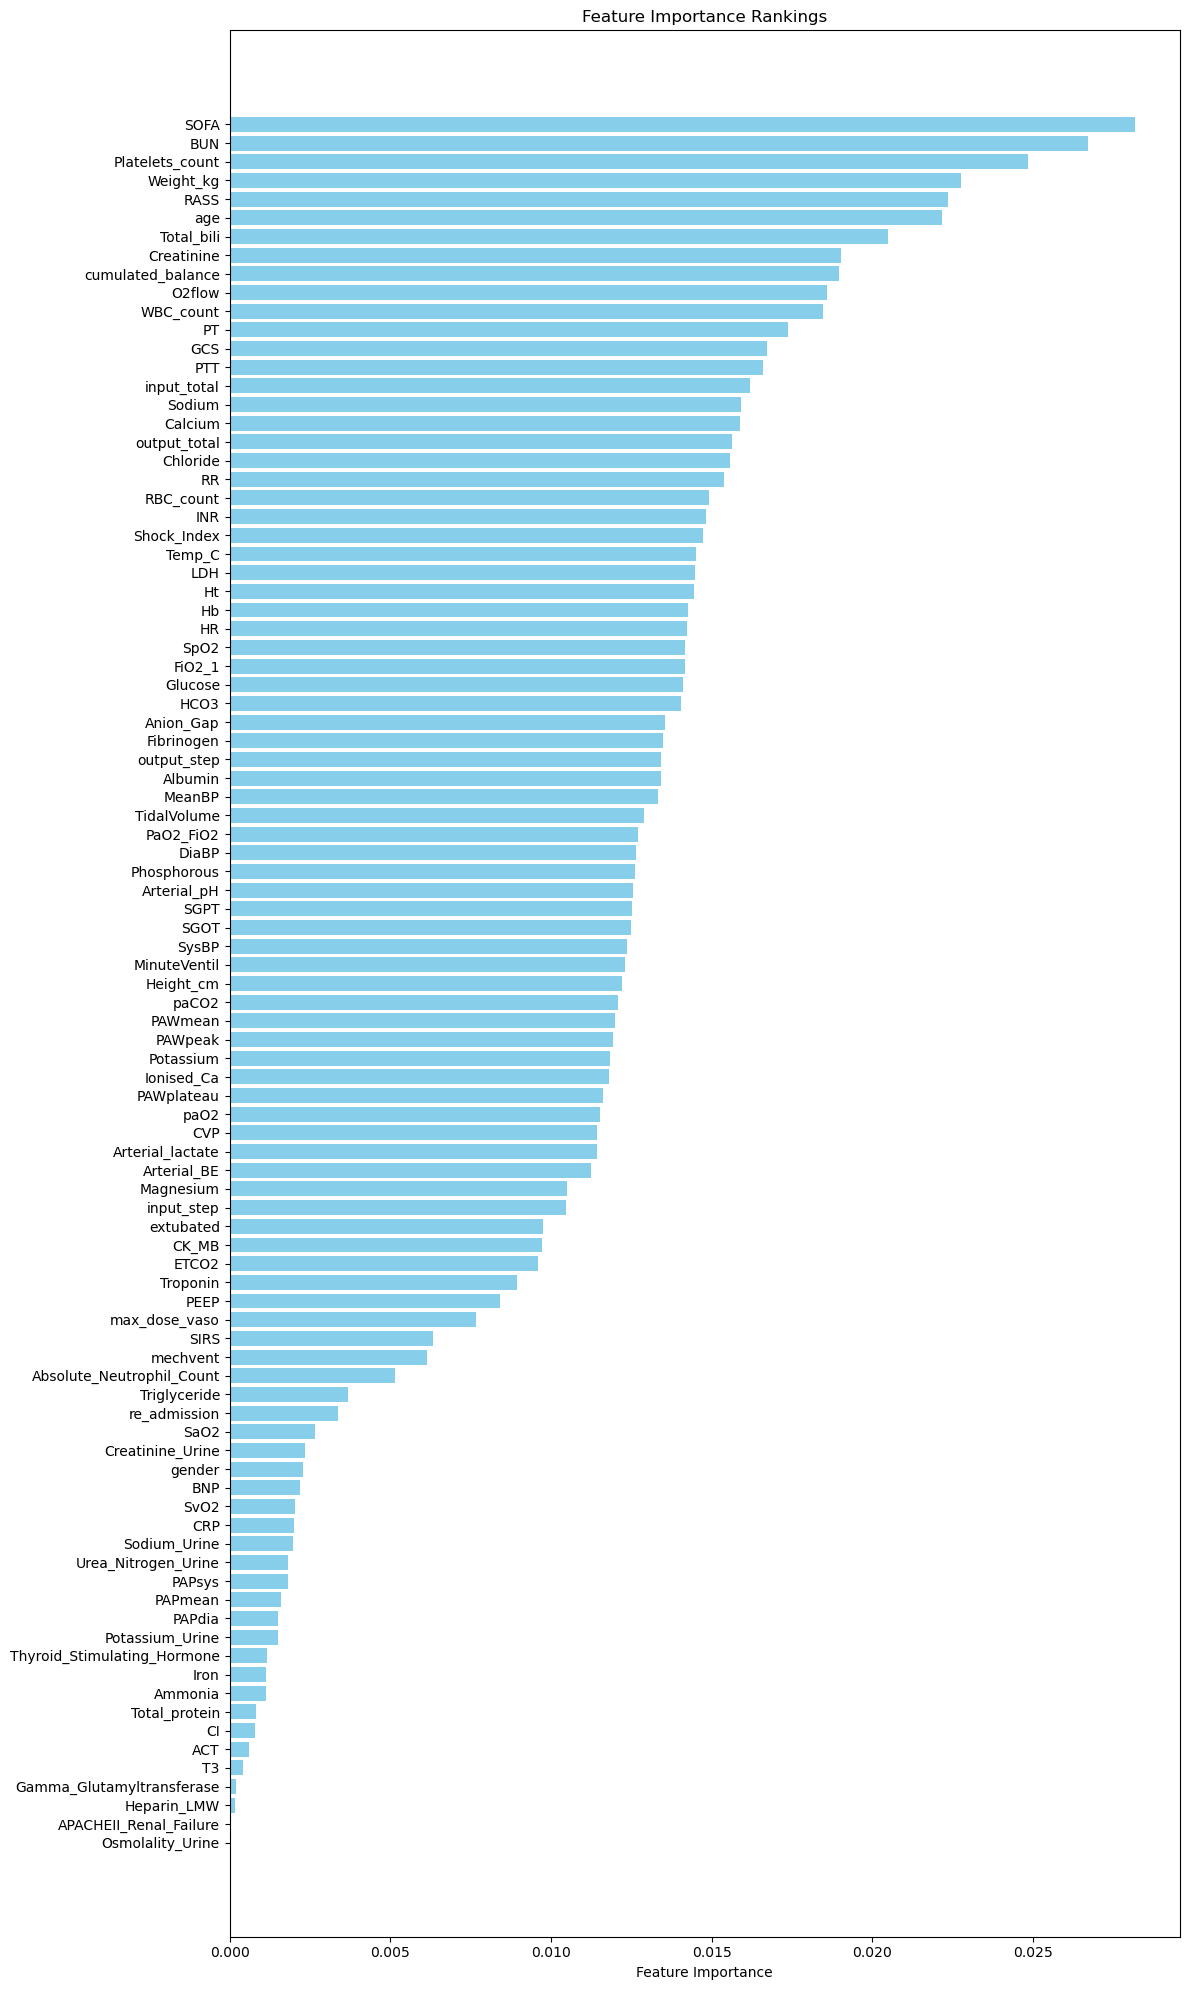

In [18]:
y_pred = model_outcome.predict(X_test)

# Evaluate Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.2f}")

# Extract Feature Importances
feature_importances_outcome = model_outcome.feature_importances_
feature_names = X_train.columns
importance_df_outcome = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_outcome
})

# Sort Features by Importance
importance_df_outcome = importance_df_outcome.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nFeature Importance Rankings:")
print(importance_df_outcome)

# Plot Feature Importances
plt.figure(figsize=(12, 20))
plt.title("Feature Importance Rankings")
plt.barh(importance_df_outcome['Feature'], importance_df_outcome['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [19]:

# Optional: Save Feature Importances to a CSV File
importance_df_outcome.to_csv(os.path.join(data_dir, "feature_importances_outcome.csv"), index=False)

AUROC: 0.83


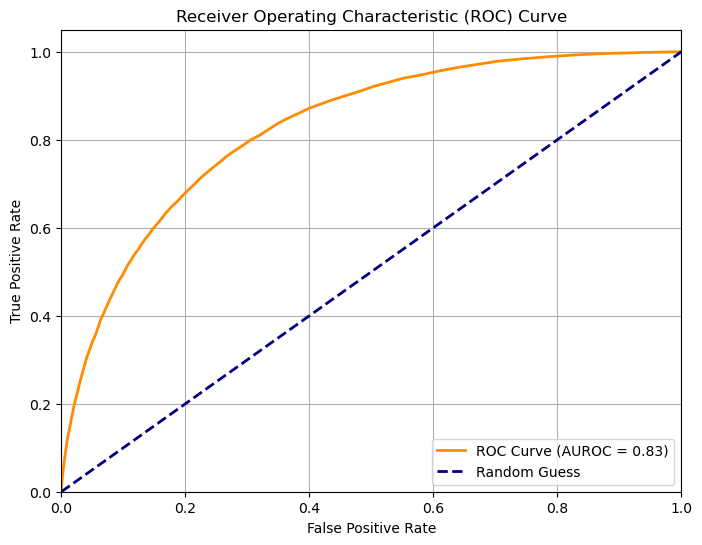

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Get predicted probabilities for the positive class (class '1')
y_prob = model_outcome.predict_proba(X_test)[:, 1]

# ===========================================
# Step 3: Compute ROC Curve and AUROC
# ===========================================

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute Area Under the ROC Curve (AUROC)
auroc = roc_auc_score(y_test, y_prob)
print(f"AUROC: {auroc:.2f}")

# ===========================================
# Step 4: Plot the ROC Curve
# ===========================================

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Feature Importances from 'feature_importances_outcome.csv':
           Feature  Importance
0             SOFA    0.028163
1              BUN    0.026697
2  Platelets_count    0.024836
3        Weight_kg    0.022761
4             RASS    0.022361 

Feature Importances from 'feature_importances.csv':
             Feature  Importance
0        output_step    0.079535
1  cumulated_balance    0.038431
2         Creatinine    0.037533
3               SOFA    0.037266
4          Anion_Gap    0.028939 

Merged Feature Importances:
                     Feature  Importance_outcome  Importance_general
0                        ACT            0.000605            0.000566
1     APACHEII_Renal_Failure            0.000004            0.000000
2  Absolute_Neutrophil_Count            0.005156            0.006064
3                    Albumin            0.013428            0.007724
4                    Ammonia            0.001141            0.000897 

Combined Feature Importances using 'Combined_Average':
 

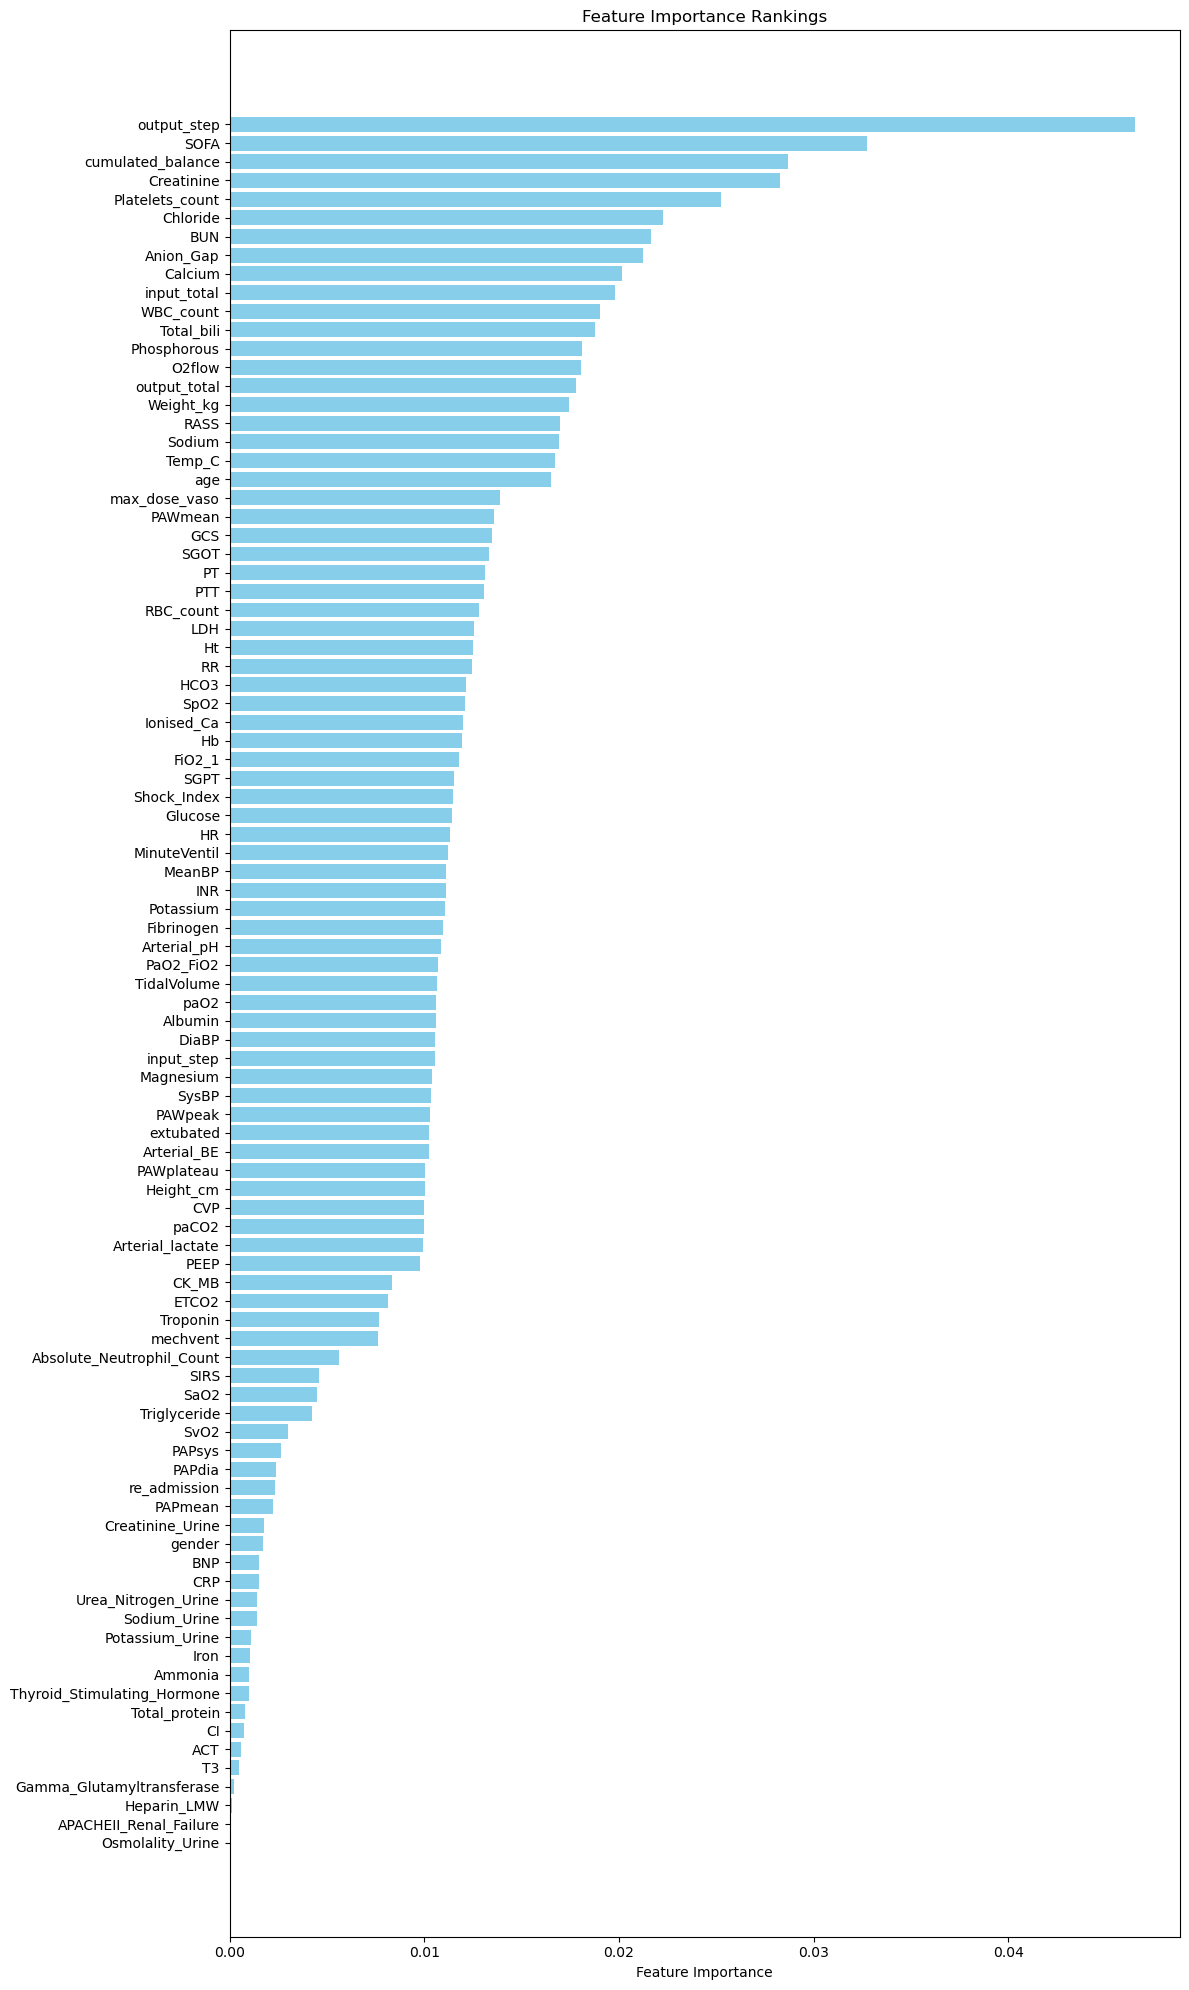

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Paths to the feature importance CSV files
importance_outcome_path = os.path.join(data_dir, "feature_importances_outcome.csv")
importance_path = os.path.join(data_dir, "feature_importances.csv")

# ===============================
# Step 1: Load the Feature Importance CSV Files
# ===============================

# Load feature importances from both CSV files
# Assuming both CSVs have 'Feature' and 'Importance' columns
importance_outcome_df = pd.read_csv(importance_outcome_path)
importance_df = pd.read_csv(importance_path)

# Display the first few rows to verify
print("Feature Importances from 'feature_importances_outcome.csv':")
print(importance_outcome_df.head(), "\n")

print("Feature Importances from 'feature_importances.csv':")
print(importance_df.head(), "\n")

# ===============================
# Step 2: Merge the Importances
# ===============================

# Merge the two DataFrames on the 'Feature' column
combined_df = pd.merge(
    importance_outcome_df,
    importance_df,
    on='Feature',
    how='outer',
    suffixes=('_outcome', '_general')
)

# Handle missing importances by filling with zero
combined_df['Importance_outcome'] = combined_df['Importance_outcome'].fillna(0)
combined_df['Importance_general'] = combined_df['Importance_general'].fillna(0)

# Display merged DataFrame
print("Merged Feature Importances:")
print(combined_df.head(), "\n")


# Define combination methods as functions
def combine_average(df, col1, col2):
    """Combine importances by averaging."""
    return (df[col1] + df[col2]) / 2

def combine_weighted_average(df, col1, col2, weight1=0.5, weight2=0.5):
    """Combine importances by weighted averaging."""
    return (df[col1] * weight1) + (df[col2] * weight2)

def combine_geometric_mean(df, col1, col2):
    """Combine importances using geometric mean."""
    return np.sqrt(df[col1] * df[col2])

def combine_max(df, col1, col2):
    """Combine importances by taking the maximum."""
    return df[[col1, col2]].max(axis=1)

def combine_min(df, col1, col2):
    """Combine importances by taking the minimum."""
    return df[[col1, col2]].min(axis=1)

def combine_average_rank(df, col1, col2):
    """Combine importances using average rank."""
    df['Rank1'] = df[col1].rank(ascending=False, method='average')
    df['Rank2'] = df[col2].rank(ascending=False, method='average')
    return df[['Rank1', 'Rank2']].mean(axis=1)

# Apply combination methods
combined_df['Combined_Average'] = combine_average(combined_df, 'Importance_outcome', 'Importance_general')
combined_df['Combined_Weighted_Average'] = combine_weighted_average(combined_df, 'Importance_outcome', 'Importance_general', weight1=0.6, weight2=0.4)  # Example weights
combined_df['Combined_GeoMean'] = combine_geometric_mean(combined_df, 'Importance_outcome', 'Importance_general')
combined_df['Combined_Max'] = combine_max(combined_df, 'Importance_outcome', 'Importance_general')
combined_df['Combined_Min'] = combine_min(combined_df, 'Importance_outcome', 'Importance_general')
combined_df['Combined_AvgRank'] = combine_average_rank(combined_df, 'Importance_outcome', 'Importance_general')

# ===============================
# Step 4: Rank and Sort the Combined Importances
# ===============================

# Choose the desired combined importance method for ranking
# For example, we'll use 'Combined_Average'
combined_method = 'Combined_Average'  # Change to desired method as needed

# Sort the DataFrame based on the chosen combined importance
combined_sorted_df = combined_df.sort_values(by=combined_method, ascending=False).reset_index(drop=True)

# Display the sorted combined importances
print(f"Combined Feature Importances using '{combined_method}':")
print(combined_sorted_df[['Feature', combined_method]].head(20), "\n")



# Save the combined sorted DataFrame to a new CSV
combined_output_path = os.path.join(data_dir, "combined_feature_importances.csv")
combined_sorted_df.to_csv(combined_output_path, index=False)
print(f"Combined feature importances saved to '{combined_output_path}'.")

# ===============================
# Optional: Visualize Multiple Combined Importances Together
# ===============================

# If you want to compare multiple combined importance methods, you can plot them together.



# Plot Feature Importances
plt.figure(figsize=(12, 20))
plt.title("Feature Importance Rankings")
plt.barh(combined_sorted_df['Feature'], combined_sorted_df['Combined_Average'], color='skyblue')
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()



In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
import seaborn as sns
import time
import warnings
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score


warnings.filterwarnings('ignore')  # To suppress warnings for cleaner output


In [23]:
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
from scipy.stats import entropy  # For accurate KL Divergence computation

def compute_similarity_metrics(model, X_test, MIMICzs_test, metadata_test, args, MIMICraw_test):
    """
    Compute similarity metrics between train and test transition matrices.
    Metrics are scaled based on the number of zeros in the transition matrices.
    """
    A = model.n_actions
    S = model.n_states

    blocs_test = metadata_test[C_BLOC].values
    stay_ids_test = metadata_test[C_ICUSTAYID].values
    outcomes_test = metadata_test[C_OUTCOME].values  # 1 if patient died, 0 if survived
    actions_test = MIMICraw_test['action'].values

    print("Evaluating on MIMIC test set...")
    states_test = model.compute_states(MIMICzs_test.values)

    records_test = build_complete_record_sequences(
        metadata_test,
        states_test,
        actions_test,
        model.absorbing_states,
        model.rewards
    )

    physpol_test, transitionr_test, R_test = compute_physician_policy(
        records_test,
        model.n_states,
        model.n_actions,
        model.absorbing_states,
        reward_val=model.reward_val,
        transition_threshold=model.transition_threshold,
    )

    # Assign transition matrices
    transition_matrix_train = model.transitionr        # Shape: (S, S, A)
    transition_matrix_test = transitionr_test          # Shape: (S, S, A)

    # =============================================
    # Scaling Metrics Based on Number of Zeros
    # =============================================

    print("Computing number of zeros in transition matrices...")
    zeros_train = np.sum(transition_matrix_train == 0)
    zeros_test = np.sum(transition_matrix_test == 0)
    total_zeros = zeros_train + zeros_test
    print(f"Number of zeros in train matrix: {zeros_train}")
    print(f"Number of zeros in test matrix: {zeros_test}")
    print(f"Total number of zeros: {total_zeros}\n")

    # Handle cases where total_zeros is zero to avoid division by zero
    if total_zeros > 0:
        scaling_factor = total_zeros
    else:
        scaling_factor = 1  # Avoid division by zero; metrics remain unscaled

    # Check for NaN values without normalization
    train_nan = np.isnan(transition_matrix_train).any()
    test_nan = np.isnan(transition_matrix_test).any()

    if train_nan or test_nan:
        print("NaN values detected in the transition matrices.")
        # Replace NaNs with zeros
        transition_matrix_train = np.nan_to_num(transition_matrix_train)
        transition_matrix_test = np.nan_to_num(transition_matrix_test)
        print("NaN values have been replaced with zeros.\n")
    else:
        print("No NaN values detected in the transition matrices.\n")

    # Compute similarity metrics
    print("Computing similarity metrics...\n")

    frobenius_norms = []
    js_divergences = []
    tv_distances = []
    
    for a in range(A):
        print(f"Action {a+1}/{A}")

        # Frobenius Norm without normalization
        diff = transition_matrix_train[:, :, a] - transition_matrix_test[:, :, a]
        fro_norm = norm(diff)

        # Scale the Frobenius norm based on the number of zeros
        fro_norm_scaled = fro_norm / scaling_factor
        frobenius_norms.append(fro_norm_scaled)
        print(f"  Frobenius Norm (scaled): {fro_norm_scaled:.6f}")

        # Jensen-Shannon Divergence
        epsilon = 1e-12
        p = transition_matrix_train[:, :, a] + epsilon
        q = transition_matrix_test[:, :, a] + epsilon

        # Re-normalize to ensure rows sum to 1 after epsilon addition
        p /= p.sum(axis=1, keepdims=True)
        q /= q.sum(axis=1, keepdims=True)

        # Compute JSD for each state
        js_div_per_state = []
        for s in range(S):
            js_div = jensenshannon(p[s], q[s], base=np.e)
            js_div_per_state.append(js_div)
        average_js_div = np.mean(js_div_per_state)

        # Scale JSD based on the number of zeros
        average_js_div_scaled = average_js_div / scaling_factor
        js_divergences.append(average_js_div_scaled)
        print(f"  Average JSD (scaled): {average_js_div_scaled:.6f}")

        # Total Variation Distance
        tv_per_state = 0.5 * np.sum(np.abs(p - q), axis=1)  # Shape: (S,)
        average_tv = np.mean(tv_per_state)

        # Scale TV Distance based on the number of zeros
        average_tv_scaled = average_tv / scaling_factor
        tv_distances.append(average_tv_scaled)
        print(f"  Average TV Distance (scaled): {average_tv_scaled:.6f}\n")

    print("Similarity metrics computation complete.\n")

    # Compute Average KL Divergence
    print("Computing Average KL Divergence...\n")
    kl_divergence_sum = 0
    for s in range(S):
        for a in range(A):
            p = transition_matrix_train[s, :, a] + epsilon  # Adding epsilon to avoid log(0)
            q = transition_matrix_test[s, :, a] + epsilon
            p /= p.sum()
            q /= q.sum()
            kl_div = entropy(p, q)  # KL(p || q)
            kl_divergence_sum += kl_div

    average_kl_divergence = kl_divergence_sum / (S * A)

    # Scale KL Divergence based on the number of zeros
    average_kl_divergence_scaled = average_kl_divergence * scaling_factor

    print(f"Average KL Divergence (scaled): {average_kl_divergence_scaled:.6f}\n")

    # Compile metrics into a dictionary
    metrics = {
        'Frobenius_Norm': frobenius_norms,
        'Average_JSD': js_divergences,
        'Average_TV_Distance': tv_distances,
        'Average_KL_Divergence': average_kl_divergence_scaled
    }

    return metrics


Total number of features: 93
Feature counts to evaluate: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 93]

=== Running experiment with top 10 features ===

Selected top 10 features: ['output_step', 'SOFA', 'cumulated_balance', 'Creatinine', 'Platelets_count', 'Chloride', 'BUN', 'Anion_Gap', 'Calcium', 'input_total']

Clustering
Zeroing out 466/1404 transitions
Create reward matrix R(S, A)
Evaluating on MIMIC test set...
Zeroing out 542/1404 transitions
Create reward matrix R(S, A)
Normalizing transition matrices...
Normalization complete.

No NaN values detected in the normalized matrices.

Computing similarity metrics...

Action 1/2
  Frobenius Norm: 4.890178
  Average JSD: 0.414679
  Average TV Distance: 0.369083

Action 2/2
  Frobenius Norm: 17.267217
  Average JSD: 0.440793
  Average TV Distance: 0.508194

Similarity metrics computation complete.

Average KL Divergence: 0.009218412288403076
Metrics for top 10 features:
  Number_of_Features: 10
  Frobenius_No

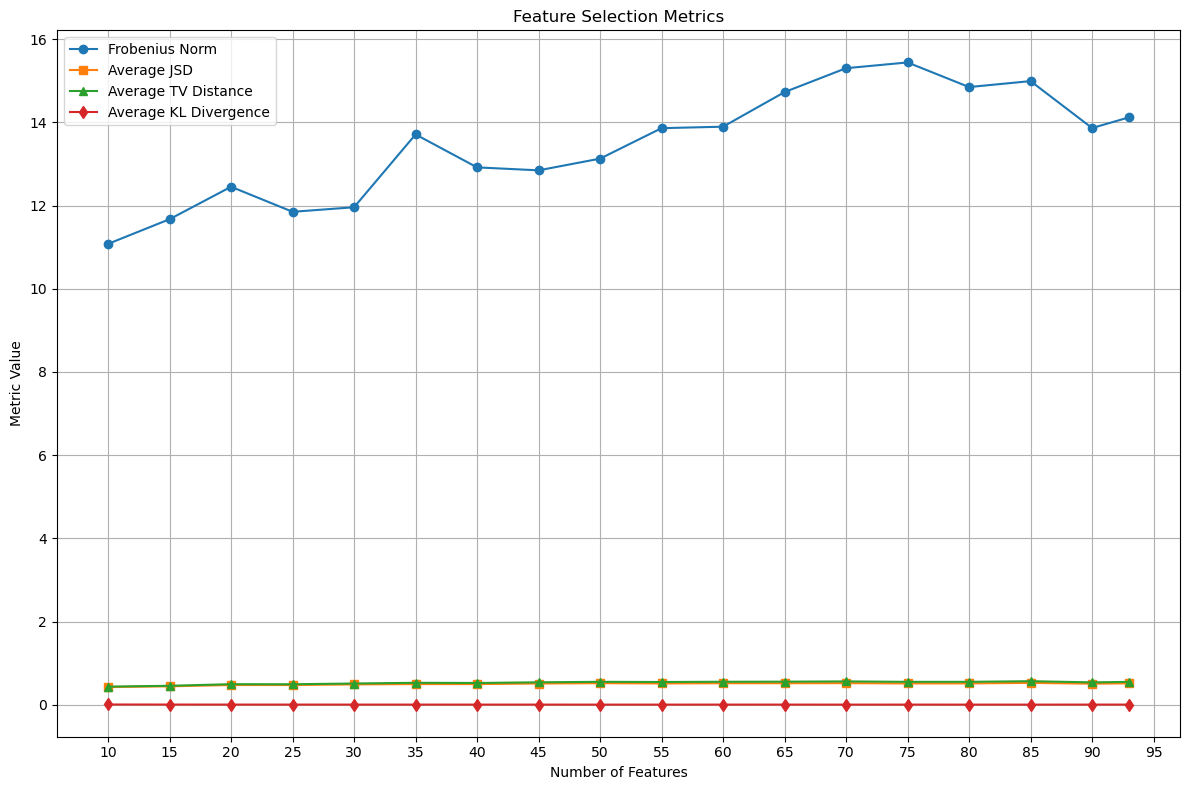

The best set of features is the top 10 features based on the combined metrics.
Best feature set saved to '/home/lkapral/RRT_mimic_iv/data/model/best_feature_set.txt'.



In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
import seaborn as sns
import time
import warnings
import sklearn
warnings.filterwarnings('ignore')  # To suppress warnings for cleaner output

# ===============================
# Step 1: Define Helper Functions
# ===============================

def combine_feature_importances(outcome_path, general_path):
    """
    Load and combine feature importances from two CSV files.
    """
    # Load feature importances
    importance_outcome_df = pd.read_csv(outcome_path)
    importance_general_df = pd.read_csv(general_path)
    
    # Ensure both DataFrames have 'Feature' and 'Importance' columns
    required_columns = {'Feature', 'Importance'}
    if not required_columns.issubset(importance_outcome_df.columns) or not required_columns.issubset(importance_general_df.columns):
        raise ValueError("Both CSV files must contain 'Feature' and 'Importance' columns.")
    
    # Merge on 'Feature'
    combined_df = pd.merge(
        importance_outcome_df,
        importance_general_df,
        on='Feature',
        how='outer',
        suffixes=('_outcome', '_general')
    )
    
    # Fill missing importances with 0
    combined_df['Importance_outcome'] = combined_df['Importance_outcome'].fillna(0)
    combined_df['Importance_general'] = combined_df['Importance_general'].fillna(0)
    
    # Compute combined importance (e.g., average)
    combined_df['Combined_Average'] = (combined_df['Importance_outcome'] + combined_df['Importance_general']) / 2
    
    # Sort by combined importance descending
    combined_df = combined_df.sort_values(by='Combined_Average', ascending=False).reset_index(drop=True)
    
    return combined_df

def plot_feature_importances(df, feature_col, importance_col, title, top_n=20):
    """
    Plot the top_n feature importances.
    """
    plt.figure(figsize=(10, 8))
    top_features = df.head(top_n)
    sns.barplot(x=importance_col, y=feature_col, data=top_features, palette='viridis')
    plt.xlabel('Combined Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def compute_similarity_metrics(model, X_test, MIMICzs_test, metadata_test, args, MIMICraw_test):
    """
    Compute similarity metrics between train and test transition matrices.
    """
    A = model.n_actions
    S = model.n_states
    
    blocs_test = metadata_test[C_BLOC].values
    stay_ids_test = metadata_test[C_ICUSTAYID].values
    outcomes_test = metadata_test[C_OUTCOME].values  # 1 if patient died, 0 if survived
    actions_test = MIMICraw_test['action'].values

    print("Evaluating on MIMIC test set...")
    states_test = model.compute_states(MIMICzs_test.values)

    records_test = build_complete_record_sequences(
        metadata_test,
        states_test,
        actions_test,
        model.absorbing_states,
        model.rewards
    )

    physpol_test, transitionr_test, R_test = compute_physician_policy(
        records_test,
        model.n_states,
        model.n_actions,
        model.absorbing_states,
        reward_val=model.reward_val,
        transition_threshold=model.transition_threshold
    )

    # Assign transition matrices
    transition_matrix_train = model.transitionr        # Shape: (S, S, A)
    transition_matrix_test = transitionr_test          # Shape: (S, S, A)

    # Normalize transition matrices
    def normalize_transition_matrix(matrix, A, S):
        normalized_matrix = np.zeros_like(matrix)
        for a in range(A):
            row_sums = matrix[:, :, a].sum(axis=1, keepdims=True)  # Shape: (S, 1)
            zero_rows = (row_sums == 0).flatten()  # Shape: (S,)
            row_sums[zero_rows] = 1.0  # To avoid division by zero
            normalized_matrix[:, :, a] = matrix[:, :, a] / row_sums
            normalized_matrix[zero_rows, :, a] = 0.0
        return normalized_matrix

    print("Normalizing transition matrices...")
    transition_matrix_train_normalized = normalize_transition_matrix(transition_matrix_train, A, S)
    transition_matrix_test_normalized = normalize_transition_matrix(transition_matrix_test, A, S)
    print("Normalization complete.\n")

    # Check for NaN values
    train_nan = np.isnan(transition_matrix_train_normalized).any()
    test_nan = np.isnan(transition_matrix_test_normalized).any()

    if train_nan or test_nan:
        print("NaN values detected in the normalized matrices.")
        # Replace NaNs with zeros
        transition_matrix_train_normalized = np.nan_to_num(transition_matrix_train_normalized)
        transition_matrix_test_normalized = np.nan_to_num(transition_matrix_test_normalized)
        print("NaN values have been replaced with zeros.\n")
    else:
        print("No NaN values detected in the normalized matrices.\n")

    # Compute similarity metrics
    print("Computing similarity metrics...\n")

    frobenius_norms = []
    js_divergences = []
    tv_distances = []
    
    for a in range(A):
        print(f"Action {a+1}/{A}")

        # Frobenius Norm
        diff = transition_matrix_train_normalized[:, :, a] - transition_matrix_test_normalized[:, :, a]
        fro_norm = norm(diff)
        frobenius_norms.append(fro_norm)
        print(f"  Frobenius Norm: {fro_norm:.6f}")

        # Jensen-Shannon Divergence
        epsilon = 1e-12
        p = transition_matrix_train_normalized[:, :, a] + epsilon
        q = transition_matrix_test_normalized[:, :, a] + epsilon

        # Re-normalize to ensure rows sum to 1 after epsilon addition
        p /= p.sum(axis=1, keepdims=True)
        q /= q.sum(axis=1, keepdims=True)

        # Compute JSD for each state
        js_div_per_state = []
        for s in range(S):
            js_div = jensenshannon(p[s], q[s], base=np.e)
            js_div_per_state.append(js_div)
        average_js_div = np.mean(js_div_per_state)
        js_divergences.append(average_js_div)
        print(f"  Average JSD: {average_js_div:.6f}")

        # Total Variation Distance
        tv_per_state = 0.5 * np.sum(np.abs(p - q), axis=1)  # Shape: (S,)
        average_tv = np.mean(tv_per_state)
        tv_distances.append(average_tv)
        print(f"  Average TV Distance: {average_tv:.6f}\n")

    print("Similarity metrics computation complete.\n")

    entropy_mean = 0
    for s in range(S):
        for a in range(A):
            entropy_mean += sklearn.metrics.mutual_info_score(transition_matrix_train[:,s,1], transition_matrix_test[:,s,1])
    
    
    average_kl_divergence = entropy_mean/S/A

    print('Average KL Divergence:', average_kl_divergence)

    # Compile metrics into a dictionary
    metrics = {
        'Frobenius_Norm': frobenius_norms,
        'Average_JSD': js_divergences,
        'Average_TV_Distance': tv_distances,
        'Average_KL_Divergence': average_kl_divergence
    }

    return metrics

# ===============================
# Step 2: Set Up Experiment Parameters
# ===============================

# Paths to feature importance CSV files
importance_outcome_path = os.path.join(data_dir, "feature_importances_outcome.csv")
importance_general_path = os.path.join(data_dir, "feature_importances.csv")

# Combine feature importances
combined_df = combine_feature_importances(importance_outcome_path, importance_general_path)

# Define the range of feature counts to iterate over
start_features = 10
step_size = 5
total_features = combined_df.shape[0]
feature_counts = list(range(start_features, total_features + 1, step_size))
if feature_counts[-1] != total_features:
    feature_counts.append(total_features)  # Ensure the last step includes all features

print(f"Total number of features: {total_features}")
print(f"Feature counts to evaluate: {feature_counts}\n")

# Initialize a list to store all metrics
metrics_records = []

# ===============================
# Step 3: Define Additional Parameters and Column

# Model parameters
number_of_clusters = 700
cluster_fraction = 0.25
cluster_init = 32
reward_value = 100
transition_threshold = 5
n_actions = 2

# ===============================
# Step 4: Iterate Over Feature Subsets and Run Tests
# ===============================

for num_features in feature_counts:
    print(f"=== Running experiment with top {num_features} features ===\n")
    start_time = time.time()
    
    # Select top N features
    top_features = combined_df['Feature'].head(num_features).tolist()
    print(f"Selected top {num_features} features: {top_features}\n")
    
    # Load Training Data
    MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
    MIMICzs_train = pd.read_csv(os.path.join(data_dir, "train", "MIMICzs.csv"))
    metadata_train = load_csv(os.path.join(data_dir, "train", "metadata.csv"))
    
    # Load Testing Data
    MIMICraw_test = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
    MIMICzs_test = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
    metadata_test = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
    
    # Filter MIMICzs to include only top_features
    MIMICzs_train = MIMICzs_train[top_features]
    MIMICzs_test = MIMICzs_test[top_features]
    
    # Define 'action' column based on rrt_cols
    rrt_actions_train = (~MIMICraw_train[rrt_cols].isna() & (MIMICraw_train[rrt_cols] != 0)).any(axis=1)
    MIMICraw_train['action'] = rrt_actions_train.astype(int)
    
    rrt_actions_test = (~MIMICraw_test[rrt_cols].isna() & (MIMICraw_test[rrt_cols] != 0)).any(axis=1)
    MIMICraw_test['action'] = rrt_actions_test.astype(int)
    
    MIMICzs_train['RRT'] = MIMICraw_train['action'] 
    MIMICzs_test['RRT'] = MIMICraw_test['action'] 



    
    
    # Drop rrt_cols from MIMICzs
    MIMICzs_train.drop(columns=rrt_cols, inplace=True, errors='ignore')
    MIMICzs_test.drop(columns=rrt_cols, inplace=True, errors='ignore')
    
    # Prepare Features and Target
    X_train = MIMICzs_train
    actions_train = MIMICraw_train['action'].values
    X_test = MIMICzs_test
    actions_test = MIMICraw_test['action'].values
    
    # Initialize the AIClinicianModel
    try:
        base_model = AIClinicianModel(
            n_cluster_states=number_of_clusters,
            n_actions=n_actions,
            cluster_fit_fraction=cluster_fraction,
            n_cluster_init=cluster_init,
            gamma=args.gamma,
            reward_val=reward_value,
            transition_threshold=transition_threshold
        )
    except Exception as e:
        print(f"Error initializing AIClinicianModel: {e}")
        continue  # Skip to the next iteration
    
    model = base_model
    
    # Set clustering (perform clustering once)
    try:
        base_model.set_clustering(
            X_train.values,
            actions_train,
            metadata_train,
        )
    except Exception as e:
        print(f"Error during clustering: {e}")
        continue  # Skip to the next iteration
    
    # Compute similarity metrics
    try:
        metrics = compute_similarity_metrics(
            model=model,
            X_test=X_test,
            MIMICzs_test=MIMICzs_test,
            metadata_test=metadata_test,
            args=args,
            MIMICraw_test=MIMICraw_test
        )
    except Exception as e:
        print(f"Error computing similarity metrics: {e}")
        continue  # Skip to the next iteration
    
    # Collect metrics with the current number of features
    metrics_record = {
        'Number_of_Features': num_features,
        'Frobenius_Norm_Average': np.mean(metrics['Frobenius_Norm']),
        'Average_JSD': np.mean(metrics['Average_JSD']),
        'Average_TV_Distance': np.mean(metrics['Average_TV_Distance']),
        'Average_KL_Divergence': metrics['Average_KL_Divergence']
    }
    metrics_records.append(metrics_record)
    
    # Log the metrics
    print(f"Metrics for top {num_features} features:")
    for key, value in metrics_record.items():
        print(f"  {key}: {value}")
    print("\n")
    
    # Optional: Save intermediate metrics to avoid data loss in case of interruption
    metrics_df = pd.DataFrame(metrics_records)
    metrics_df.to_csv(os.path.join(data_dir, "feature_selection_metrics.csv"), index=False)
    
    # Print elapsed time for the current iteration
    elapsed_time = time.time() - start_time
    print(f"Completed experiment with top {num_features} features in {elapsed_time/60:.2f} minutes.\n")
    print("="*60 + "\n")

# ===============================
# Step 5: Save All Metrics After Experiments
# ===============================

# Convert the metrics_records list to a DataFrame
final_metrics_df = pd.DataFrame(metrics_records)

# Save the final metrics to a CSV file
final_metrics_path = os.path.join(data_dir, "feature_selection_final_metrics.csv")
final_metrics_df.to_csv(final_metrics_path, index=False)
print(f"All feature selection metrics saved to '{final_metrics_path}'.\n")

# ===============================
# Step 6: Visualization of Metrics
# ===============================

# Plotting the metrics to find the best set of features
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 8))
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Frobenius_Norm_Average'], marker='o', label='Frobenius Norm')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_JSD'], marker='s', label='Average JSD')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_TV_Distance'], marker='^', label='Average TV Distance')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_KL_Divergence'], marker='d', label='Average KL Divergence')
plt.xlabel('Number of Features')
plt.ylabel('Metric Value')
plt.title('Feature Selection Metrics')
plt.legend()
plt.grid(True)
plt.xticks(final_metrics_df['Number_of_Features'])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=step_size))
plt.tight_layout()
plt.show()

# ===============================
# Step 7: Determine the Best Feature Set
# ===============================

# Define criteria to determine the best feature set
# This could be based on a combination of metrics or a specific threshold
# For simplicity, let's assume we want to minimize all metrics

# Find the row with minimum sum of normalized metrics
# Normalize metrics for fair comparison
metrics_to_consider = ['Frobenius_Norm_Average', 'Average_JSD', 'Average_TV_Distance', 'Average_KL_Divergence']
normalized_metrics = final_metrics_df.copy()
for metric in metrics_to_consider:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val - min_val != 0:
        normalized_metrics[metric] = (normalized_metrics[metric] - min_val) / (max_val - min_val)
    else:
        normalized_metrics[metric] = 0  # If all values are the same
    
# Compute the sum of normalized metrics
normalized_metrics['Combined_Score'] = normalized_metrics[metrics_to_consider].sum(axis=1)

# Identify the feature set with the lowest combined score
best_feature_set = normalized_metrics.loc[normalized_metrics['Combined_Score'].idxmin()]
best_num_features = int(best_feature_set['Number_of_Features'])
print(f"The best set of features is the top {best_num_features} features based on the combined metrics.")

# Optionally, save the best feature set
best_features = combined_df['Feature'].head(best_num_features).tolist()
best_features_path = os.path.join(data_dir, "best_feature_set.txt")
with open(best_features_path, 'w') as f:
    for feature in best_features:
        f.write(f"{feature}\n")
print(f"Best feature set saved to '{best_features_path}'.\n")

# ===============================
# End of Script
# ===============================


Total number of features: 93
Feature counts to evaluate: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 93]

=== Running experiment with top 10 features ===

Selected top 10 features: ['output_step', 'SOFA', 'cumulated_balance', 'Creatinine', 'Platelets_count', 'Chloride', 'BUN', 'Anion_Gap', 'Calcium', 'input_total']

Clustering
Feature_weights set up: [0.5296478  0.37275363 0.3269207  0.32219348 0.28755396 0.25339267
 0.24651714 0.2420002  0.22970531 0.22549439 1.        ]
Zeroing out 586/1404 transitions
Create reward matrix R(S, A)
Evaluating on MIMIC test set...
Zeroing out 642/1404 transitions
Create reward matrix R(S, A)
Normalizing transition matrices...
Normalization complete.

No NaN values detected in the normalized matrices.

Computing similarity metrics...

Action 1/2
  Frobenius Norm: 4.027023
  Average JSD: 0.397651
  Average TV Distance: 0.358087

Action 2/2
  Frobenius Norm: 4.868333
  Average JSD: 0.049629
  Average TV Distance: 0.054973

Similar

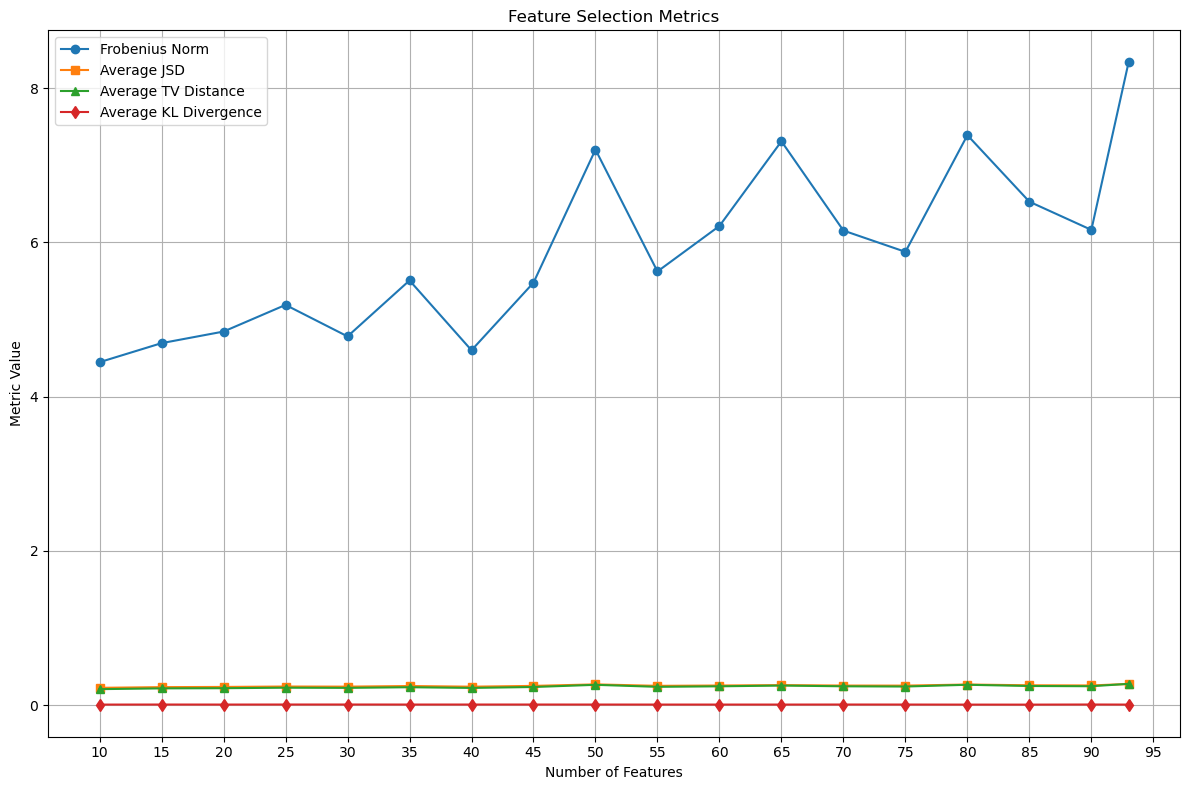

The best set of features is the top 10 features based on the combined metrics.
Best feature set saved to '/home/lkapral/RRT_mimic_iv/data/model/best_feature_set.txt'.



In [25]:

# ===============================
# Step 2: Set Up Experiment Parameters
# ===============================

# Paths to feature importance CSV files
importance_outcome_path = os.path.join(data_dir, "feature_importances_outcome.csv")
importance_general_path = os.path.join(data_dir, "feature_importances.csv")

# Combine feature importances
combined_df = combine_feature_importances(importance_outcome_path, importance_general_path)

# Define the range of feature counts to iterate over
start_features = 10
step_size = 5
total_features = combined_df.shape[0]
feature_counts = list(range(start_features, total_features + 1, step_size))
if feature_counts[-1] != total_features:
    feature_counts.append(total_features)  # Ensure the last step includes all features

print(f"Total number of features: {total_features}")
print(f"Feature counts to evaluate: {feature_counts}\n")

# Initialize a list to store all metrics
metrics_records = []

# ===============================
# Step 3: Define Additional Parameters and Column

# Model parameters
number_of_clusters = 700
cluster_fraction = 0.25
cluster_init = 32
reward_value = 100
transition_threshold = 5
n_actions = 2

# ===============================
# Step 4: Iterate Over Feature Subsets and Run Tests
# ===============================

for num_features in feature_counts:
    print(f"=== Running experiment with top {num_features} features ===\n")
    start_time = time.time()
    
    # Select top N features
    top_features = combined_df['Feature'].head(num_features).tolist()
    print(f"Selected top {num_features} features: {top_features}\n")
    
    # Load Training Data
    MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
    MIMICzs_train = pd.read_csv(os.path.join(data_dir, "train", "MIMICzs.csv"))
    metadata_train = load_csv(os.path.join(data_dir, "train", "metadata.csv"))
    
    # Load Testing Data
    MIMICraw_test = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
    MIMICzs_test = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
    metadata_test = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
    
    # Filter MIMICzs to include only top_features
    MIMICzs_train = MIMICzs_train[top_features]
    MIMICzs_test = MIMICzs_test[top_features]
    
    # Define 'action' column based on rrt_cols
    rrt_actions_train = (~MIMICraw_train[rrt_cols].isna() & (MIMICraw_train[rrt_cols] != 0)).any(axis=1)
    MIMICraw_train['action'] = rrt_actions_train.astype(int)
    
    rrt_actions_test = (~MIMICraw_test[rrt_cols].isna() & (MIMICraw_test[rrt_cols] != 0)).any(axis=1)
    MIMICraw_test['action'] = rrt_actions_test.astype(int)
    
    # Drop rrt_cols from MIMICzs
    MIMICzs_train.drop(columns=rrt_cols, inplace=True, errors='ignore')
    MIMICzs_test.drop(columns=rrt_cols, inplace=True, errors='ignore')
    
    MIMICzs_train['RRT'] = MIMICraw_train['action'] 
    MIMICzs_test['RRT'] = MIMICraw_test['action'] 

    # Prepare Features and Target
    X_train = MIMICzs_train
    actions_train = MIMICraw_train['action'].values
    X_test = MIMICzs_test
    actions_test = MIMICraw_test['action'].values
    
    # Initialize the AIClinicianModel
    try:
        base_model = AIClinicianModel(
            n_cluster_states=number_of_clusters,
            n_actions=n_actions,
            cluster_fit_fraction=cluster_fraction,
            n_cluster_init=cluster_init,
            gamma=args.gamma,
            reward_val=reward_value,
            transition_threshold=transition_threshold
        )
    except Exception as e:
        print(f"Error initializing AIClinicianModel: {e}")
        continue  # Skip to the next iteration
    
    model = base_model
    
    # Set clustering (perform clustering once)

    weights = combined_df.head(num_features)['Combined_Average'].values
    norm_weights = weights / np.linalg.norm(weights)
    norm_weights = np.append(norm_weights,1)
    base_model.set_clustering(
        X_train.values,
        actions_train,
        metadata_train,
        feature_weights=norm_weights
    )


    # Compute similarity metrics
    try:
        weights = combined_df.head(num_features)['Combined_Average'].values
        norm_weights = weights / np.linalg.norm(weights)
        metrics = compute_similarity_metrics(
            model=model,
            X_test=X_test,
            MIMICzs_test=MIMICzs_test,
            metadata_test=metadata_test,
            args=args,
            MIMICraw_test=MIMICraw_test,

        )
    except Exception as e:
        print(f"Error computing similarity metrics: {e}")
        continue  # Skip to the next iteration
    
    # Collect metrics with the current number of features
    metrics_record = {
        'Number_of_Features': num_features,
        'Frobenius_Norm_Average': np.mean(metrics['Frobenius_Norm']),
        'Average_JSD': np.mean(metrics['Average_JSD']),
        'Average_TV_Distance': np.mean(metrics['Average_TV_Distance']),
        'Average_KL_Divergence': metrics['Average_KL_Divergence']
    }
    metrics_records.append(metrics_record)
    
    # Log the metrics
    print(f"Metrics for top {num_features} features:")
    for key, value in metrics_record.items():
        print(f"  {key}: {value}")
    print("\n")
    
    # Optional: Save intermediate metrics to avoid data loss in case of interruption
    metrics_df = pd.DataFrame(metrics_records)
    metrics_df.to_csv(os.path.join(data_dir, "feature_selection_metrics_weighted.csv"), index=False)
    
    # Print elapsed time for the current iteration
    elapsed_time = time.time() - start_time
    print(f"Completed experiment with top {num_features} features in {elapsed_time/60:.2f} minutes.\n")
    print("="*60 + "\n")

# ===============================
# Step 5: Save All Metrics After Experiments
# ===============================

# Convert the metrics_records list to a DataFrame
final_metrics_df = pd.DataFrame(metrics_records)

# Save the final metrics to a CSV file
final_metrics_path = os.path.join(data_dir, "feature_selection_final_metrics_weighted.csv")
final_metrics_df.to_csv(final_metrics_path, index=False)
print(f"All feature selection metrics saved to '{final_metrics_path}'.\n")

# ===============================
# Step 6: Visualization of Metrics
# ===============================

# Plotting the metrics to find the best set of features
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 8))
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Frobenius_Norm_Average'], marker='o', label='Frobenius Norm')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_JSD'], marker='s', label='Average JSD')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_TV_Distance'], marker='^', label='Average TV Distance')
plt.plot(final_metrics_df['Number_of_Features'], final_metrics_df['Average_KL_Divergence'], marker='d', label='Average KL Divergence')
plt.xlabel('Number of Features')
plt.ylabel('Metric Value')
plt.title('Feature Selection Metrics')
plt.legend()
plt.grid(True)
plt.xticks(final_metrics_df['Number_of_Features'])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=step_size))
plt.tight_layout()
plt.show()

# ===============================
# Step 7: Determine the Best Feature Set
# ===============================

# Define criteria to determine the best feature set
# This could be based on a combination of metrics or a specific threshold
# For simplicity, let's assume we want to minimize all metrics

# Find the row with minimum sum of normalized metrics
# Normalize metrics for fair comparison
metrics_to_consider = ['Frobenius_Norm_Average', 'Average_JSD', 'Average_TV_Distance', 'Average_KL_Divergence']
normalized_metrics = final_metrics_df.copy()
for metric in metrics_to_consider:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val - min_val != 0:
        normalized_metrics[metric] = (normalized_metrics[metric] - min_val) / (max_val - min_val)
    else:
        normalized_metrics[metric] = 0  # If all values are the same
    
# Compute the sum of normalized metrics
normalized_metrics['Combined_Score'] = normalized_metrics[metrics_to_consider].sum(axis=1)

# Identify the feature set with the lowest combined score
best_feature_set = normalized_metrics.loc[normalized_metrics['Combined_Score'].idxmin()]
best_num_features = int(best_feature_set['Number_of_Features'])
print(f"The best set of features is the top {best_num_features} features based on the combined metrics.")

# Optionally, save the best feature set
best_features = combined_df['Feature'].head(best_num_features).tolist()
best_features_path = os.path.join(data_dir, "best_feature_set.txt")
with open(best_features_path, 'w') as f:
    for feature in best_features:
        f.write(f"{feature}\n")
print(f"Best feature set saved to '{best_features_path}'.\n")

# ===============================
# End of Script
# ===============================


In [26]:
norm_weights

array([3.59735476e-01, 2.53173344e-01, 2.22043732e-01, 2.18833015e-01,
       1.95305943e-01, 1.72103676e-01, 1.67433830e-01, 1.64365936e-01,
       1.56015278e-01, 1.53155231e-01, 1.47261949e-01, 1.45382183e-01,
       1.40203471e-01, 1.39484847e-01, 1.37493466e-01, 1.34826811e-01,
       1.31221718e-01, 1.30803693e-01, 1.29250075e-01, 1.27784482e-01,
       1.07441351e-01, 1.04947825e-01, 1.04238561e-01, 1.03232890e-01,
       1.01434830e-01, 1.01111239e-01, 9.89684250e-02, 9.72684500e-02,
       9.66412697e-02, 9.63676265e-02, 9.37599794e-02, 9.34119535e-02,
       9.28337933e-02, 9.22122699e-02, 9.10788908e-02, 8.91967912e-02,
       8.86757622e-02, 8.85310301e-02, 8.76873415e-02, 8.67619814e-02,
       8.61954705e-02, 8.58113853e-02, 8.56351412e-02, 8.49914086e-02,
       8.42071341e-02, 8.29647838e-02, 8.25699186e-02, 8.21473539e-02,
       8.18469642e-02, 8.17840179e-02, 8.16367354e-02, 8.05593607e-02,
       7.98805537e-02, 7.97866763e-02, 7.94020915e-02, 7.93907773e-02,
      

Fixed number of features: 40
Number of clusters to evaluate: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]

Selected top 40 features: ['output_step', 'SOFA', 'cumulated_balance', 'Creatinine', 'Platelets_count', 'Chloride', 'BUN', 'Anion_Gap', 'Calcium', 'input_total', 'WBC_count', 'Total_bili', 'Phosphorous', 'O2flow', 'output_total', 'Weight_kg', 'RASS', 'Sodium', 'Temp_C', 'age', 'max_dose_vaso', 'PAWmean', 'GCS', 'SGOT', 'PT', 'PTT', 'RBC_count', 'LDH', 'Ht', 'RR', 'HCO3', 'SpO2', 'Ionised_Ca', 'Hb', 'FiO2_1', 'SGPT', 'Shock_Index', 'Glucose', 'HR', 'MinuteVentil']

=== Running experiment with 50 clusters ===

Clustering
Feature_weights set up: [0.3943926  0.27756421 0.24343556 0.23991552 0.21412183 0.18868424
 0.1835645  0.18020105 0.17104588 0.1679103  0.16144925 0.15938839
 0.15371076 0.1529229  0.15073967 0.1478161  0.1438637  0.1434054
 0.1417021  0.14009531 0.117

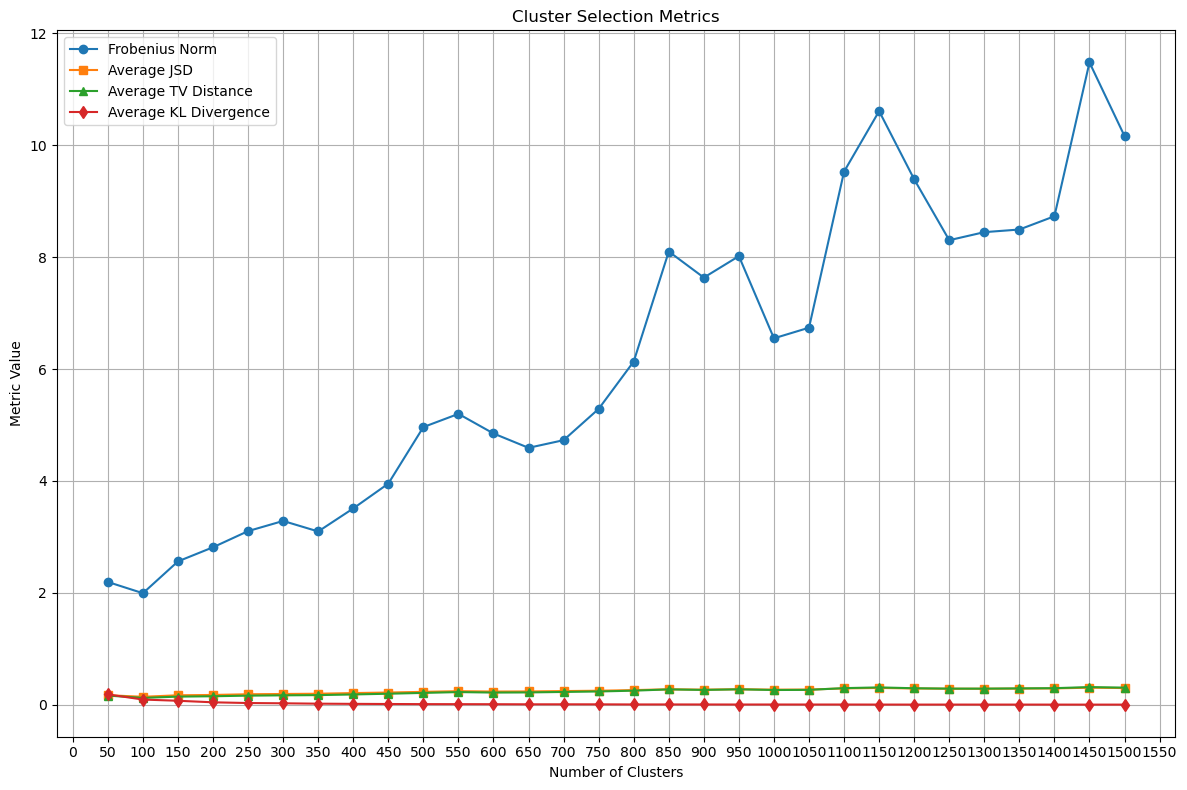

The best number of clusters is 100 based on the combined metrics.
Best cluster count saved to '/home/lkapral/RRT_mimic_iv/data/model/best_cluster_count.txt'.



In [27]:


# ===============================
# Step 2: Set Up Experiment Parameters
# ===============================

# Paths to feature importance CSV files
importance_outcome_path = os.path.join(data_dir, "feature_importances_outcome.csv")
importance_general_path = os.path.join(data_dir, "feature_importances.csv")

# Combine feature importances
combined_df = combine_feature_importances(importance_outcome_path, importance_general_path)

# ===============================
# Step 3: Define Additional Parameters and Columns
# ===============================

# Fixed number of features
fixed_num_features = 40

# Define the range of number of clusters to iterate over with step size 50
start_clusters = 50
step_size = 50
max_clusters = 1500  # Define based on your dataset and computational resources
cluster_counts = list(range(start_clusters, max_clusters + 1, step_size))
# Optionally, ensure the maximum cluster count does not exceed the number of data points
# cluster_counts = [c for c in cluster_counts if c <= total_data_points]

print(f"Fixed number of features: {fixed_num_features}")
print(f"Number of clusters to evaluate: {cluster_counts}\n")

# Initialize a list to store all metrics
metrics_records = []

# Model parameters
cluster_fraction = 0.25
cluster_init = 32
reward_value = 100
transition_threshold = 5
n_actions = 2

# ===============================
# Step 4: Iterate Over Cluster Counts and Run Tests
# ===============================

# Select top N features (fixed_num_features)
top_features = combined_df['Feature'].head(fixed_num_features).tolist()
print(f"Selected top {fixed_num_features} features: {top_features}\n")

# Load Training Data
MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
MIMICzs_train = pd.read_csv(os.path.join(data_dir, "train", "MIMICzs.csv"))
metadata_train = load_csv(os.path.join(data_dir, "train", "metadata.csv"))

# Load Testing Data
MIMICraw_test = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))
MIMICzs_test = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata_test = load_csv(os.path.join(data_dir, "test", "metadata.csv"))

# Filter MIMICzs to include only top_features
MIMICzs_train = MIMICzs_train[top_features]
MIMICzs_test = MIMICzs_test[top_features]

# Define 'action' column based on rrt_cols
rrt_actions_train = (~MIMICraw_train[rrt_cols].isna() & (MIMICraw_train[rrt_cols] != 0)).any(axis=1)
MIMICraw_train['action'] = rrt_actions_train.astype(int)

rrt_actions_test = (~MIMICraw_test[rrt_cols].isna() & (MIMICraw_test[rrt_cols] != 0)).any(axis=1)
MIMICraw_test['action'] = rrt_actions_test.astype(int)

# Drop rrt_cols from MIMICzs
MIMICzs_train.drop(columns=rrt_cols, inplace=True, errors='ignore')
MIMICzs_test.drop(columns=rrt_cols, inplace=True, errors='ignore')


# Prepare Features and Target
X_train = MIMICzs_train
actions_train = MIMICraw_train['action'].values
X_test = MIMICzs_test
actions_test = MIMICraw_test['action'].values

MIMICzs_train['RRT'] = MIMICraw_train['action'] 
MIMICzs_test['RRT'] = MIMICraw_test['action'] 

# Define feature weights based on combined importance
weights = combined_df.head(fixed_num_features)['Combined_Average'].values
norm_weights = weights / np.linalg.norm(weights)
norm_weights = np.append(norm_weights,1)

for num_clusters in cluster_counts:
    print(f"=== Running experiment with {num_clusters} clusters ===\n")
    start_time = time.time()
    
    # Initialize the AIClinicianModel with the current number of clusters
    try:
        base_model = AIClinicianModel(
            n_cluster_states=num_clusters,  # Varying number of clusters
            n_actions=n_actions,
            cluster_fit_fraction=cluster_fraction,
            n_cluster_init=cluster_init,
            gamma=args.gamma,  # Ensure 'args' is defined appropriately
            reward_val=reward_value,
            transition_threshold=transition_threshold
        )
    except Exception as e:
        print(f"Error initializing AIClinicianModel with {num_clusters} clusters: {e}")
        continue  # Skip to the next iteration
    
    model = base_model
    
    # Set clustering (perform clustering once)
    try:
        model.set_clustering(
            X_train.values,
            actions_train,
            metadata_train,
            feature_weights=norm_weights
        )
    except Exception as e:
        print(f"Error during clustering with {num_clusters} clusters: {e}")
        continue  # Skip to the next iteration
    
    # Compute similarity metrics
    try:
        metrics = compute_similarity_metrics(
            model=model,
            X_test=X_test,
            MIMICzs_test=MIMICzs_test,
            metadata_test=metadata_test,
            args=args,
            MIMICraw_test=MIMICraw_test,
        )
    except Exception as e:
        print(f"Error computing similarity metrics with {num_clusters} clusters: {e}")
        continue  # Skip to the next iteration
    
    # Collect metrics with the current number of clusters
    metrics_record = {
        'Number_of_Clusters': num_clusters,
        'Frobenius_Norm_Average': np.mean(metrics['Frobenius_Norm']),
        'Average_JSD': np.mean(metrics['Average_JSD']),
        'Average_TV_Distance': np.mean(metrics['Average_TV_Distance']),
        'Average_KL_Divergence': metrics['Average_KL_Divergence']
    }
    metrics_records.append(metrics_record)
    
    # Log the metrics
    print(f"Metrics for {num_clusters} clusters:")
    for key, value in metrics_record.items():
        print(f"  {key}: {value}")
    print("\n")
    
    # Optional: Save intermediate metrics to avoid data loss in case of interruption
    metrics_df = pd.DataFrame(metrics_records)
    metrics_df.to_csv(os.path.join(data_dir, f"cluster_selection_metrics_{fixed_num_features}.csv"), index=False)
    
    # Print elapsed time for the current iteration
    elapsed_time = time.time() - start_time
    print(f"Completed experiment with {num_clusters} clusters in {elapsed_time/60:.2f} minutes.\n")
    print("="*60 + "\n")

# ===============================
# Step 5: Save All Metrics After Experiments
# ===============================

# Convert the metrics_records list to a DataFrame
final_metrics_df = pd.DataFrame(metrics_records)

# Save the final metrics to a CSV file
final_metrics_path = os.path.join(data_dir, f"cluster_selection_final_metrics_{fixed_num_features}.csv")
final_metrics_df.to_csv(final_metrics_path, index=False)
print(f"All cluster selection metrics saved to '{final_metrics_path}'.\n")

# ===============================
# Step 6: Visualization of Metrics
# ===============================

# Plotting the metrics to find the best number of clusters
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 8))
plt.plot(final_metrics_df['Number_of_Clusters'], final_metrics_df['Frobenius_Norm_Average'], marker='o', label='Frobenius Norm')
plt.plot(final_metrics_df['Number_of_Clusters'], final_metrics_df['Average_JSD'], marker='s', label='Average JSD')
plt.plot(final_metrics_df['Number_of_Clusters'], final_metrics_df['Average_TV_Distance'], marker='^', label='Average TV Distance')
plt.plot(final_metrics_df['Number_of_Clusters'], final_metrics_df['Average_KL_Divergence'], marker='d', label='Average KL Divergence')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Value')
plt.title('Cluster Selection Metrics')
plt.legend()
plt.grid(True)
plt.xticks(final_metrics_df['Number_of_Clusters'])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=step_size))
plt.tight_layout()
plt.show()

# ===============================
# Step 7: Determine the Best Cluster Count
# ===============================

# Define criteria to determine the best cluster count
# This could be based on a combination of metrics or a specific threshold
# For simplicity, let's assume we want to minimize all metrics

# Find the row with minimum sum of normalized metrics
# Normalize metrics for fair comparison
metrics_to_consider = ['Frobenius_Norm_Average', 'Average_JSD', 'Average_TV_Distance', 'Average_KL_Divergence']
normalized_metrics = final_metrics_df.copy()
for metric in metrics_to_consider:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val - min_val != 0:
        normalized_metrics[metric] = (normalized_metrics[metric] - min_val) / (max_val - min_val)
    else:
        normalized_metrics[metric] = 0  # If all values are the same
    
# Compute the sum of normalized metrics
normalized_metrics['Combined_Score'] = normalized_metrics[metrics_to_consider].sum(axis=1)

# Identify the cluster count with the lowest combined score
best_cluster_set = normalized_metrics.loc[normalized_metrics['Combined_Score'].idxmin()]
best_num_clusters = int(best_cluster_set['Number_of_Clusters'])
print(f"The best number of clusters is {best_num_clusters} based on the combined metrics.")

# Optionally, save the best cluster count
best_cluster_path = os.path.join(data_dir, "best_cluster_count.txt")
with open(best_cluster_path, 'w') as f:
    f.write(f"{best_num_clusters}\n")
print(f"Best cluster count saved to '{best_cluster_path}'.\n")

# ===============================
# End of Script
# ===============================
